<hr>
<h3>Задание №3</h3>

<p>Выполните задание № 2 средствами SQLAlchemy, включая создание
и редактирование таблиц, а также выполнение таких запросов, как:</p>
<ul>
    <li><p>вывод фамилий всех авторов, родившихся в диапазоне между X и Y годами (задайте программно числа X и Y);</p></li>
    <li><p>вывод всех книг, написанных авторами из России;</p></li>
    <li><p>вывод всех книг с количеством страниц более N;</p></li>
    <li><p>вывод всех авторов с числом книг более N.</p></li>
</ul>
<hr>

In [ ]:
import hashlib
import re
import sys

# Parsing
import json
import xml.etree.ElementTree as ET

# PyQt
from PyQt5 import QtWidgets, QtGui, QtCore

# SQLAlchemy
import sqlalchemy
from sqlalchemy.sql import func
from sqlalchemy.orm import sessionmaker, relationship
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, ForeignKey, create_engine, MetaData

In [ ]:
DBNAME = r'library.db'

engine = sqlalchemy.create_engine('sqlite:///' + DBNAME, echo=False)

Base = declarative_base()
metadata = MetaData(bind=engine)


class Authors(Base):
    __tablename__ = 'authors'
    
    id = Column(Integer, primary_key=True)
    name = Column(String, nullable=False)
    country = Column(String, nullable=False)
    years_birth = Column(Integer, nullable=False)
    years_death = Column(Integer, nullable=False)
    books = relationship('Books', back_populates='authors')
    
    def __repr__(self):
        return "<Authors(name='%s', country='%s', years='%s')>" % (
                        self.name, self.country, str(f'[{self.years_birth}, {self.years_death}]'))


class Books(Base):
    __tablename__ = 'books'
    
    id = Column(Integer, primary_key=True)
    author_id = Column(Integer, ForeignKey('authors.id'))
    title = Column(String, nullable=False)
    pages = Column(Integer, nullable=False)
    publisher = Column(String, nullable=False)
    year = Column(Integer, nullable=False)
    authors = relationship('Authors', back_populates='books')
    
    def __repr__(self):
        return "<Books(title='%s', pages='%d', publisher='%s', year='%d')>" % (
                        self.title, self.pages, self.publisher, self.year)

class Users(Base):
    __tablename__ = 'users'
    
    id = Column(Integer, primary_key=True)
    login = Column(String, nullable=False, unique=True)
    password = Column(String, nullable=False)
    
    def __repr__(self):
        return "<Users(login='%s', password='%s')>" % (
                        self.login, self.password)
    
Base.metadata.create_all(engine)

Session = sessionmaker(bind=engine)
session = Session()

In [ ]:
def user_authorize(login, password):
    users = [(users.login, users.password) 
                  for users in session.query(Users)]
        
    for item in users:
        curr_login = item[0]
        curr_password = item[1]

        if login == curr_login:
            hashed_password = hashlib.md5(password.encode('utf-8')).hexdigest()
            
            if hashed_password == curr_password:
                print("Login is successful")
                return True

            else:
                print("Invalid password!")
                return False

    print("Invalid login!")
    return False
        
def add_user_authorize(login, password):
    login = str(login).strip()
    password = str(password).strip()

    if not re.match(r'^[a-zA-Z0-9_]+$', login):
        print("\n -- Error --\n Incorrect login!")
        return

    if not re.match(r'^[a-zA-Z0-9_]+$', password):
        print("\n -- Error --\n Incorrect password!")
        return
    
    hashed_password = hashlib.md5(password.encode('utf-8')).hexdigest()

    users = Users(login=login, password=hashed_password)
    session.add(users)
    session.commit()

In [ ]:
'''
# Test regex func:
login = "Loger424_BOML "
login = login.strip()

if not re.match(r'^[a-zA-Z0-9_]+$', login):
    print("No! Login is incorrect!!")
else:
    print("Yes! Login is correct!!") 
'''
None

In [ ]:
'''
# Test login functionality:
login = "Login123"
password = "users12345"

# add_user_authorize(login, password)
user_authorize(login, password)
'''
None

In [ ]:
def print_all_authors():
    authors = [(authors.id, authors.name, authors.country, authors.years_birth, authors.years_death) 
                  for authors in session.query(Authors)]
    
    list_of_authors = []

    for author in authors:
        id = author[0]
        name = author[1]
        country = author[2]
        years_birth = int(author[3])
        years_death = int(author[4])

        print("  Id: {0}\n  Name: {1}\n  Country: {2}\n  Years of Life: {3}\n"
              .format(id, name, country, str(f'[{years_birth}, {years_death}]')))
        

        author_to_list = [id, name, country, str(f'[{years_birth}, {years_death}]')]
        list_of_authors.append(author_to_list)

    return list_of_authors
            
            
def print_all_books():
    books = [(books.id, books.authors.name, books.title, books.pages, books.publisher, books.year) 
                  for books in session.query(Books)]
    
    list_of_books = []

    for book in books:
        id = book[0]
        author = book[1]
        title = book[2]
        pages = int(book[3])
        publisher = book[4]
        year = int(book[5])

        print("  Id: {0}\n  Author: {1}\n  Title: {2}\n  Pages: {3}\n  Publisher: {4}\n  Year: {5}\n"
              .format(id, author, title, pages, publisher, year))

        books_to_list = [id, author, title, pages, publisher, year]
        list_of_books.append(books_to_list)

    return list_of_books

In [ ]:
def add_author(name, country, years_of_life):
    name = str(name).strip()
    country = str(country).strip()
    years_birth = years_of_life[0]
    years_death = years_of_life[1]

    if name == '' or country == '' or years_birth == 0 or years_death == 0:
        print("Empty value!")
        return
    
    authors = Authors(name=name, country=country, years_birth=years_birth, years_death=years_death)
    session.add(authors)
    session.commit()
        
def add_book(author, title, pages, publisher, year):
    try:
        author = int(author)
        title = str(title).strip()
        pages = int(pages)
        publisher = str(publisher).strip()
        year = int(year)
    except ValueError as e:
        print(e)

    if title == '' or publisher == '':
        print("Empty value!")
        return
    
    authors = session.query(Authors) \
                       .filter(Authors.id == author) \
                       .first()
    
    if authors:
        books = Books(title=title, pages=pages, publisher=publisher, year=year)
        authors.books.append(books)
        session.add(books)
        session.flush()
        session.commit()
    else:    
        print('No such performer!')

In [ ]:
'''
# Test add value to the author:
name = "L.N.Tolstoi"
country = "Russia"
years_of_life = str([1828, 1910])

add_author(name, country, years_of_life)
'''
None

In [ ]:
'''
print_all_authors()
'''
None

In [ ]:
'''
# Test add value to the author:
author = 1
title = "Война и мир"
pages = 1300
publisher = "Русский вестник"
year = 1865

add_book(author, title, pages, publisher, year)
'''
None

In [ ]:
'''
print_all_books()
'''
None

In [ ]:
def save_in_json(data):
    json_data = {
        'name': data[0],
        'country': data[1],
        'years': data[2]
    }
    
    with open('author.json', 'w') as f:
        json.dump(json_data, f)
        
def save_in_xml(data):
    root = ET.Element('author')
    
    name = ET.SubElement(root, 'name')
    name.text = data[0]
    
    country = ET.SubElement(root, 'country')
    country.text = data[1]
    
    years = ET.SubElement(root, 'years', {'born': str(data[2][0]), 'died': str(data[2][1])})

    tree = ET.ElementTree(root)
    
    tree.write('author.xml', xml_declaration=True, encoding='utf-8')

In [ ]:
'''
# Json save
data = ['L.N.Tolstoi', 'Russia', [1828, 1910]]
save_in_json(data)

#XML save
save_in_xml(data)
'''
None

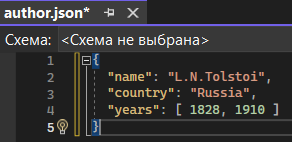 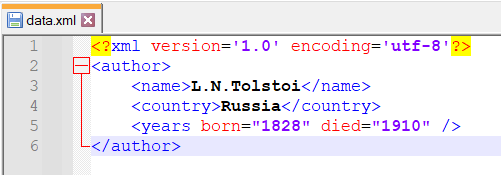

In [ ]:
def formated_data(data):
    new_data = []
    new_data.append(data['name'])
    new_data.append(data['country'])
    new_data.append(data['years'])
    
    return new_data

def read_from_json(path):
    with open(path, 'r') as f:
        json_data = json.load(f)
    
    formated_json_data = formated_data(json_data)
    return formated_json_data

def read_from_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    xml_data = {
        'name': root.find('name').text,
        'country': root.find('country').text,
        'years': [int(root.find('years').get('born')), int(root.find('years').get('died'))]
    }
    
    formated_xml_data = formated_data(xml_data)
    return formated_xml_data

In [ ]:
'''
# Read Json file:
path_json = 'C:\\Users\\Raviolka\\author.json'
json_data = read_from_json(path_json)
print(json_data)

# Read Xml file:
path_xml = 'C:\\Users\\Raviolka\\author.xml'
xml_data = read_from_xml(path_xml)
print(xml_data)
'''
None

<h1>Filters</h1>
<ul>
    <li><p>вывод фамилий всех авторов, родившихся в диапазоне между X и Y годами (задайте программно числа X и Y);</p></li>
    <li><p>вывод всех книг, написанных авторами из России;</p></li>
    <li><p>вывод всех книг с количеством страниц более N;</p></li>
    <li><p>вывод всех авторов с числом книг более N.</p></li>
</ul>

In [ ]:
def filter_1(x, y):
    authors = session.query(Authors).filter(Authors.years_birth.between(x, y)).all()
    
    items_list = []
    for author in authors:
        items = QtWidgets.QListWidgetItem(f"Author name: '{author.name}'")
#         Если мы хотим вывести всю информацию об авторе.
#         items = QtWidgets.QListWidgetItem("Id: {0}    Name: {1}    Country: {2}    Years of Life: {3}"
#               .format(author.id, author.name, author.country, str(f'[{author.years_birth}, {author.years_death}]')))
        items_list.append(items)
        
    return items_list

In [ ]:
def filter_2():
    books = session.query(Books).join(Authors).filter(Authors.country == 'Russia').all()
    
    items_list = []
    for book in books:
        items = QtWidgets.QListWidgetItem(f"Book title: '{book.title}'")
#         Если мы хотим вывести всю информацию о книге.
#         items = QtWidgets.QListWidgetItem("Id: {0}    Author: {1}    Title: {2}    Pages: {3}    Publisher: {4}    Year: {5}"
#               .format(book.id, book.authors.name, book.title, book.pages, book.publisher, book.year))
        items_list.append(items)
        
    return items_list

In [ ]:
def filter_3(N):
    books = session.query(Books).filter(Books.pages > N).all()
    
    items_list = []
    for book in books:
        items = QtWidgets.QListWidgetItem(f"Book title: '{book.title}'")
#         Если мы хотим вывести всю информацию о книге.
#         items = QtWidgets.QListWidgetItem("Id: {0}    Author: {1}    Title: {2}    Pages: {3}    Publisher: {4}    Year: {5}"
#               .format(book.id, book.authors.name, book.title, book.pages, book.publisher, book.year))
        items_list.append(items)
        
    return items_list

In [ ]:
def filter_4(N):
    authors = session.query(Authors,  func.count(Books.id)) \
        .join(Books).group_by(Authors.id) \
        .having(func.count(Books.id) > N).all()
    
    items_list = []
    for author in authors:
        items = QtWidgets.QListWidgetItem(f"Author name: '{author.Authors.name}    Count of books: '{author[1]}'")
#         Если мы хотим вывести всю информацию об авторе.
#         items = QtWidgets.QListWidgetItem("Id: {0}    Name: {1}    Country: {2}    Years of Life: {3}"
#               .format(author.Authors.id, author.Authors.name, author.Authors.country, str(f'[{author.Authors.years_birth}, {author.Authors.years_death}]')))
        items_list.append(items)
        
    return items_list

In [ ]:
class LoginDialog(QtWidgets.QDialog):
    def __init__(self, parent=None):
        super(LoginDialog, self).__init__(parent)
        self.setWindowTitle('Login')
        self.resize(250, 200)

        # Создание виджетов
        self.user_label = QtWidgets.QLabel('Username:')
        self.user_text = QtWidgets.QLineEdit()
        self.pass_label = QtWidgets.QLabel('Password:')
        self.pass_text = QtWidgets.QLineEdit()
        self.pass_text.setEchoMode(QtWidgets.QLineEdit.Password)
        self.login_button = QtWidgets.QPushButton('Login')
        self.create_button = QtWidgets.QPushButton('Create new user')

        # Создание сетки для расположения виджетов
        grid = QtWidgets.QGridLayout()
        grid.addWidget(self.user_label, 0, 0, QtCore.Qt.AlignRight)
        grid.addWidget(self.user_text, 0, 1)
        grid.addWidget(self.pass_label, 1, 0, QtCore.Qt.AlignRight)
        grid.addWidget(self.pass_text, 1, 1)
        grid.addWidget(self.login_button, 2, 0, 1, 2)
        grid.addWidget(self.create_button, 3, 0, 1, 2)

        # Установка сетки для окна
        self.setLayout(grid)

        # Обработчик нажатия на кнопку
        self.login_button.clicked.connect(self.on_login_button)
        self.create_button.clicked.connect(self.on_create_button)

    def on_login_button(self):
        # Вызов метода авторизации
        if user_authorize(self.user_text.text(), self.pass_text.text()):
            self.accept()
        else:
            QtWidgets.QMessageBox.critical(self, 'Error', 'Login failed. Please try again.')
            
    def on_create_button(self):
        # Открытие диалогового окна для создания нового пользователя
        dlg = CreateUserDialog(self)
        if dlg.exec_() == QtWidgets.QDialog.Accepted:
            # Вызов метода добавления нового пользователя
            add_user_authorize(dlg.user_text.text(), dlg.pass_text.text())
            QtWidgets.QMessageBox.information(self, 'Success', 'User created successfully. You can now login with your new account.')
        dlg.deleteLater()
        
class CreateUserDialog(QtWidgets.QDialog):
    def __init__(self, parent=None):
        super(CreateUserDialog, self).__init__(parent)
        self.setWindowTitle('Create new user')
        self.resize(250, 150)

        # Создание виджетов
        self.user_label = QtWidgets.QLabel('Username:')
        self.user_text = QtWidgets.QLineEdit()
        self.pass_label = QtWidgets.QLabel('Password:')
        self.pass_text = QtWidgets.QLineEdit()
        self.pass_text.setEchoMode(QtWidgets.QLineEdit.Password)
        self.create_button = QtWidgets.QPushButton('Create')

        # Создание сетки для расположения виджетов
        grid = QtWidgets.QGridLayout()
        grid.addWidget(self.user_label, 0, 0, QtCore.Qt.AlignRight)
        grid.addWidget(self.user_text, 0, 1)
        grid.addWidget(self.pass_label, 1, 0, QtCore.Qt.AlignRight)
        grid.addWidget(self.pass_text, 1, 1)
        grid.addWidget(self.create_button, 2, 0, 1, 2)

        # Установка сетки для окна
        self.setLayout(grid)

        # Обработчик нажатия на кнопку
        self.create_button.clicked.connect(self.on_create_button)

    def on_create_button(self):
        # Проверка наличия введенных данных
        if not self.user_text.text() or not self.pass_text.text():
            QtWidgets.QMessageBox.critical(self, 'Error', 'Please enter username and password.')
            return

        # Закрытие окна с результатом QDialog.Accepted
        self.accept()

In [ ]:
class MainWidget(QtWidgets.QWidget):
    def __init__(self, parent=None):
        super().__init__(parent)
        self.authors = []
        self.books = []
        self.selected_author = None
        self.init_ui()

    def init_ui(self):
        self.filterWin = None
        
        self.setWindowTitle('Библиотека')
        self.resize(900, 500)
  
        author_label = QtWidgets.QLabel('Авторы:')
        self.author_list = QtWidgets.QListWidget()
        self.author_list.itemSelectionChanged.connect(self.author_selected)
        self.add_author_button = QtWidgets.QPushButton('Добавить автора')
        self.add_author_button.clicked.connect(self.add_author)
        
        book_label = QtWidgets.QLabel('Книги:')
        self.book_list = QtWidgets.QListWidget()
        self.add_book_button = QtWidgets.QPushButton('Добавить книгу')
        self.add_book_button.clicked.connect(self.add_book)
        
        save_button = QtWidgets.QPushButton('Сохранить в файл')
        save_button.clicked.connect(self.save_to_file)
        open_button = QtWidgets.QPushButton('Открыть файл')
        open_button.clicked.connect(self.open_file)        
        filter_button = QtWidgets.QPushButton('Фильтры')
        filter_button.clicked.connect(self.open_filters_form)
        
        layout = QtWidgets.QVBoxLayout()
        
        author_layout = QtWidgets.QVBoxLayout()
        author_layout.addWidget(author_label)
        author_layout.addWidget(self.author_list)
        author_layout.addWidget(self.add_author_button)
        
        book_layout = QtWidgets.QVBoxLayout()
        book_layout.addWidget(book_label)
        book_layout.addWidget(self.book_list)
        book_layout.addWidget(self.add_book_button)

        button_layout = QtWidgets.QHBoxLayout()
        button_layout.addWidget(save_button)
        button_layout.addWidget(open_button)
        button_layout.addWidget(filter_button)
        
        layout.addLayout(author_layout)
        layout.addLayout(book_layout)
        layout.addLayout(button_layout)
        
        self.setLayout(layout)
        
        self.update_author_list()
        self.update_book_list()

    def update_author_list(self):
        self.authors = print_all_authors()

        self.author_list.clear()
        for author in self.authors:
            item = QtWidgets.QListWidgetItem(f"Name: '{author[1]}' Country: '{author[2]}' Years: '{author[3]}'")
            self.author_list.addItem(item)

    def update_book_list(self):
        self.books = print_all_books()

        self.book_list.clear()
        for book in self.books:
            item = QtWidgets.QListWidgetItem(f"Author: '{book[1]}' Title: '{book[2]}' Pages: '{book[3]}' Publisher: '{book[4]}' Year: '{book[5]}'")
            self.book_list.addItem(item)
            
    def add_author(self):
        dialog = AddAuthorDialog(self)
        if dialog.exec_() == QtWidgets.QDialog.Accepted:
            author_data = dialog.get_author_data()
            
            if author_data != None:
                add_author(author_data[0], 
                           author_data[1], 
                           author_data[2],)

                self.update_author_list()
        
    def add_book(self):
        dialog = AddBookDialog(self)
        if dialog.exec_() == QtWidgets.QDialog.Accepted:
            book_data = dialog.get_book_data()
            
            if book_data != None:
                add_book(book_data[0],
                         book_data[1],
                         book_data[2],
                         book_data[3],
                         book_data[4])

                self.update_book_list()
                
    def author_selected(self):
        selected_items = self.author_list.selectedItems()
        if not selected_items:
            return
        
        selected_items = selected_items[0].text().split()

        self.selected_author = [ selected_items[1][1 : -1],
                          selected_items[3][1 : -1],
                          eval(selected_items[5][1 :] + " " + selected_items[6][: -1])]

    def save_to_file(self):
        if self.selected_author is None:
            QtWidgets.QMessageBox.warning(self, 'Ошибка', 'Не выбран автор')
            return

        dialog = QtWidgets.QDialog(self)
        dialog.setWindowTitle('Выберите формат файла')
        dialog.setModal(True)
        dialog.setLayout(QtWidgets.QVBoxLayout())
        dialog.layout().addWidget(QtWidgets.QLabel('Выберите формат файла:'))

        json_radio = QtWidgets.QRadioButton('JSON')
        xml_radio = QtWidgets.QRadioButton('XML')
        
        json_radio.setChecked(True)
        
        dialog.layout().addWidget(json_radio)
        dialog.layout().addWidget(xml_radio)

        buttons = QtWidgets.QDialogButtonBox(QtWidgets.QDialogButtonBox.Ok | QtWidgets.QDialogButtonBox.Cancel, QtCore.Qt.Horizontal, self)
        dialog.layout().addWidget(buttons)

        def save():
            if json_radio.isChecked():
                save_in_json(self.selected_author)
            elif xml_radio.isChecked():
                save_in_xml(self.selected_author)
            dialog.accept()

        buttons.accepted.connect(save)
        buttons.rejected.connect(dialog.reject)

        dialog.show()
        dialog.exec_()
        
    def open_file(self):
        file_filter = 'JSON (*.json);;XML (*.xml)'
        file_path, _ = QtWidgets.QFileDialog.getOpenFileName(self, 'Выберите файл', '', file_filter)
        if file_path:
            if file_path[-4:] == ".xml":
                new_author = read_from_xml(file_path)
                add_author(new_author[0], new_author[1], new_author[2])
                
                self.update_author_list()
            elif file_path[-5:] == ".json":
                new_author = read_from_json(file_path)
                add_author(new_author[0], new_author[1], new_author[2])
                
                self.update_author_list()
            else: 
                print("Incorrect format!")
                
    def open_filters_form(self):
        if self.filterWin is None:
            self.filterWin = FilterWindow()
        self.filterWin.show()

In [ ]:
class FilterWindow(QtWidgets.QWidget):
    def __init__(self):
        super().__init__()

        self.initUI()

    def initUI(self):
        self.setWindowTitle('Filters')
        self.setGeometry(100, 100, 300, 300)

        self.list_widget = QtWidgets.QListWidget(self)

        self.button_filter_1 = QtWidgets.QPushButton('В диапазоне X и Y', self)
        self.button_filter_1.clicked.connect(self.filter_1)
        
        self.button_filter_2 = QtWidgets.QPushButton('Книги российских атворов', self)
        self.button_filter_2.clicked.connect(self.filter_2)
        
        self.button_filter_3 = QtWidgets.QPushButton('Колчество страниц больше N', self)
        self.button_filter_3.clicked.connect(self.filter_3)
        
        self.button_filter_4 = QtWidgets.QPushButton('Число книг больше N', self)
        self.button_filter_4.clicked.connect(self.filter_4)

        vbox = QtWidgets.QVBoxLayout()
        vbox.addWidget(self.list_widget)
        vbox.addWidget(self.button_filter_1)
        vbox.addWidget(self.button_filter_2)
        vbox.addWidget(self.button_filter_3)
        vbox.addWidget(self.button_filter_4)

        self.setLayout(vbox)
        
    def filter_1(self):
        self.list_widget.clear()
        
        # Числа нужно было по условию задать программно
        X = 1815
        Y = 1850
        
        items = filter_1(X, Y)
        for item in items:
            self.list_widget.addItem(item)
    
    def filter_2(self):
        self.list_widget.clear()
        
        items = filter_2()
        for item in items:
            self.list_widget.addItem(item)
    
    def filter_3(self):
        self.list_widget.clear()
        
        dialog = Get_number_Dialog()
        if dialog.exec_() == QtWidgets.QDialog.Accepted:
            N = dialog.get_values()
            
            items = filter_3(N)
            for item in items:
                self.list_widget.addItem(item)

    def filter_4(self):
        self.list_widget.clear()
        
        dialog = Get_number_Dialog()
        if dialog.exec_() == QtWidgets.QDialog.Accepted:
            N = dialog.get_values()
            
            items = filter_4(N)
            for item in items:
                self.list_widget.addItem(item)

In [ ]:
class Get_number_Dialog(QtWidgets.QDialog):
    def __init__(self, parent=None):
        super().__init__(parent)

        self.setWindowTitle('Input Dialog')

        self.label_N = QtWidgets.QLabel('Введите число N:', self)
        self.edit_N = QtWidgets.QLineEdit(self)

        self.button_box = QtWidgets.QDialogButtonBox(QtWidgets.QDialogButtonBox.Ok | QtWidgets.QDialogButtonBox.Cancel, self)

        layout = QtWidgets.QVBoxLayout(self)
        layout.addWidget(self.label_N)
        layout.addWidget(self.edit_N)
        layout.addWidget(self.button_box)

        self.button_box.accepted.connect(self.accept)
        self.button_box.rejected.connect(self.reject)

    def get_values(self):
        N = int(self.edit_N.text())
        if N < 0:
            print("Your number is small then 0!")
            return 0
        
        return N

In [ ]:
class AddAuthorDialog(QtWidgets.QDialog):
    def __init__(self, parent=None):
        super().__init__(parent)
        self.setWindowTitle('Добавление автора')
        self.setModal(True)
        self.resize(300, 200)

        # поля для автора
        self.author_name_edit = QtWidgets.QLineEdit()
        self.author_country_edit = QtWidgets.QLineEdit()
        self.author_birth_edit = QtWidgets.QSpinBox()
        self.author_death_edit = QtWidgets.QSpinBox()

        self.author_birth_edit.setMaximum(9999)
        self.author_death_edit.setMaximum(9999)

        # кнопки
        self.ok_button = QtWidgets.QPushButton('ОК')
        self.cancel_button = QtWidgets.QPushButton('Отмена')

        # размещение элементов на форме
        author_layout = QtWidgets.QFormLayout()
        author_layout.addRow('Имя:', self.author_name_edit)
        author_layout.addRow('Страна:', self.author_country_edit)
        author_layout.addRow('Год рождения:', self.author_birth_edit)
        author_layout.addRow('Год смерти:', self.author_death_edit)
        author_layout.addRow(self.ok_button, self.cancel_button)

        self.setLayout(author_layout)

        # подключение сигналов к слотам
        self.ok_button.clicked.connect(self.accept)
        self.cancel_button.clicked.connect(self.reject)

    def get_author_data(self):
        if self.author_name_edit.text() == '' or self.author_country_edit.text() == '' \
            or self.author_birth_edit.value() > 2023 or self.author_death_edit.value() > 2023:
                print('Invalid data')
                return
        
        return ([self.author_name_edit.text(),
                self.author_country_edit.text(),
                [self.author_birth_edit.value(),
                self.author_death_edit.value()]])


In [ ]:
class AddBookDialog(QtWidgets.QDialog):
    def __init__(self, parent=None):
        super().__init__(parent)
        self.setWindowTitle('Добавление книги')
        self.setModal(True)
        self.resize(300, 200)

        # поля для книги
        self.book_author_edit = QtWidgets.QLineEdit()
        self.book_title_edit = QtWidgets.QLineEdit()
        self.book_pages_edit = QtWidgets.QSpinBox()
        self.book_publisher_edit = QtWidgets.QLineEdit()
        self.book_year_edit = QtWidgets.QSpinBox()

        self.book_pages_edit.setMaximum(9999)
        self.book_year_edit.setMaximum(9999)

        # кнопки
        self.ok_button = QtWidgets.QPushButton('ОК')
        self.cancel_button = QtWidgets.QPushButton('Отмена')

        # размещение элементов на форме
        book_layout = QtWidgets.QFormLayout()
        book_layout.addRow('ID автора:', self.book_author_edit)
        book_layout.addRow('Название:', self.book_title_edit)
        book_layout.addRow('Количество страниц:', self.book_pages_edit)
        book_layout.addRow('Издательство:', self.book_publisher_edit)
        book_layout.addRow('Год издания:', self.book_year_edit)
        book_layout.addRow(self.ok_button, self.cancel_button)

        self.setLayout(book_layout)

        # подключение сигналов к слотам
        self.ok_button.clicked.connect(self.accept)
        self.cancel_button.clicked.connect(self.reject)

    def get_book_data(self):
        if self.book_author_edit.text() == '' or self.book_title_edit.text() == '' \
            or self.book_year_edit.value() > 2023:
                print('Invalid data')
                return
            
        return ([self.book_author_edit.text(),
                self.book_title_edit.text(),
                self.book_pages_edit.value(),
                self.book_publisher_edit.text(),
                self.book_year_edit.value()])

In [ ]:
if __name__ == '__main__':
    app = QtWidgets.QApplication(sys.argv)

    # Отображение окна авторизации
    dlg = LoginDialog()
    if dlg.exec_() == QtWidgets.QDialog.Accepted:
        
        # Отображение основного окна
        frame = MainWidget()
        frame.show()
        app.exec_()
    
    dlg.deleteLater()